<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPORT-PACKAGES" data-toc-modified-id="IMPORT-PACKAGES-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPORT PACKAGES</a></span><ul class="toc-item"><li><span><a href="#Import-customize-functions-for-fitting-data" data-toc-modified-id="Import-customize-functions-for-fitting-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import customize functions for fitting data</a></span></li></ul></li><li><span><a href="#LOAD-DATA" data-toc-modified-id="LOAD-DATA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LOAD DATA</a></span></li><li><span><a href="#DATA-VISUALIZATION" data-toc-modified-id="DATA-VISUALIZATION-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DATA VISUALIZATION</a></span><ul class="toc-item"><li><span><a href="#Amplification-curve-visualization" data-toc-modified-id="Amplification-curve-visualization-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Amplification curve visualization</a></span></li><li><span><a href="#Melting-Curves" data-toc-modified-id="Melting-Curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Melting Curves</a></span></li><li><span><a href="#Melting-peaks-distribution" data-toc-modified-id="Melting-peaks-distribution-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Melting peaks distribution</a></span></li></ul></li><li><span><a href="#MACHINE-LEARNING-ALGORITHM" data-toc-modified-id="MACHINE-LEARNING-ALGORITHM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MACHINE LEARNING ALGORITHM</a></span><ul class="toc-item"><li><span><a href="#Encoding-labels-and-select-dataset" data-toc-modified-id="Encoding-labels-and-select-dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Encoding labels and select dataset</a></span></li><li><span><a href="#Logistic-Regression-and-KNN" data-toc-modified-id="Logistic-Regression-and-KNN-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Logistic Regression and KNN</a></span></li><li><span><a href="#Plotting-the-Confusion-Matrixes" data-toc-modified-id="Plotting-the-Confusion-Matrixes-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plotting the Confusion Matrixes</a></span></li><li><span><a href="#Checking-panel-Results-(sample-level)" data-toc-modified-id="Checking-panel-Results-(sample-level)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Checking panel Results (sample level)</a></span></li><li><span><a href="#Running-at-Panel-level-(sample-level)-the-Confusion-Matrix-classification" data-toc-modified-id="Running-at-Panel-level-(sample-level)-the-Confusion-Matrix-classification-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Running at Panel level (sample level) the Confusion Matrix classification</a></span></li></ul></li></ul></div>

# IMPORT PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
from datetime import datetime
from pathlib import Path

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

## Import customize functions for fitting data

In [3]:
import functions.fitting_func as fitfunc
import functions.peak_finder as peakfunc
import functions.plotting_func as plotfunc
import functions.machine_learning as mlfunc
import functions.utilities as utils

utils.colourblind() # load colourblind lib

# LOAD DATA

In [4]:
df_master = pd.read_csv("data/df_master_dPCR.gz", compression='gzip', index_col=0, low_memory=False)
df_AC_bs_filt = pd.read_csv("data/df_AC_bs_pos.gz", compression='gzip', index_col=0, low_memory=False)
df_MC_filt = pd.read_csv("data/df_MC_pos.gz", compression='gzip', index_col=0, low_memory=False)

In [5]:
NMETA = 6 # number of meta columns (use for skipping)

# setting column index as int (after reading csv)
df_master = utils.order_columns(df_master, NMETA=NMETA+1)
df_MC_filt = utils.order_columns(df_MC_filt, NMETA=NMETA)
df_AC_bs_filt = utils.order_columns(df_AC_bs_filt, NMETA=NMETA)

# DATA VISUALIZATION
## Amplification curve visualization

In [6]:
train_plot = df_AC_bs_filt.loc[df_AC_bs_filt.Conc != 'unk']
train_plot.shape

(29165, 50)

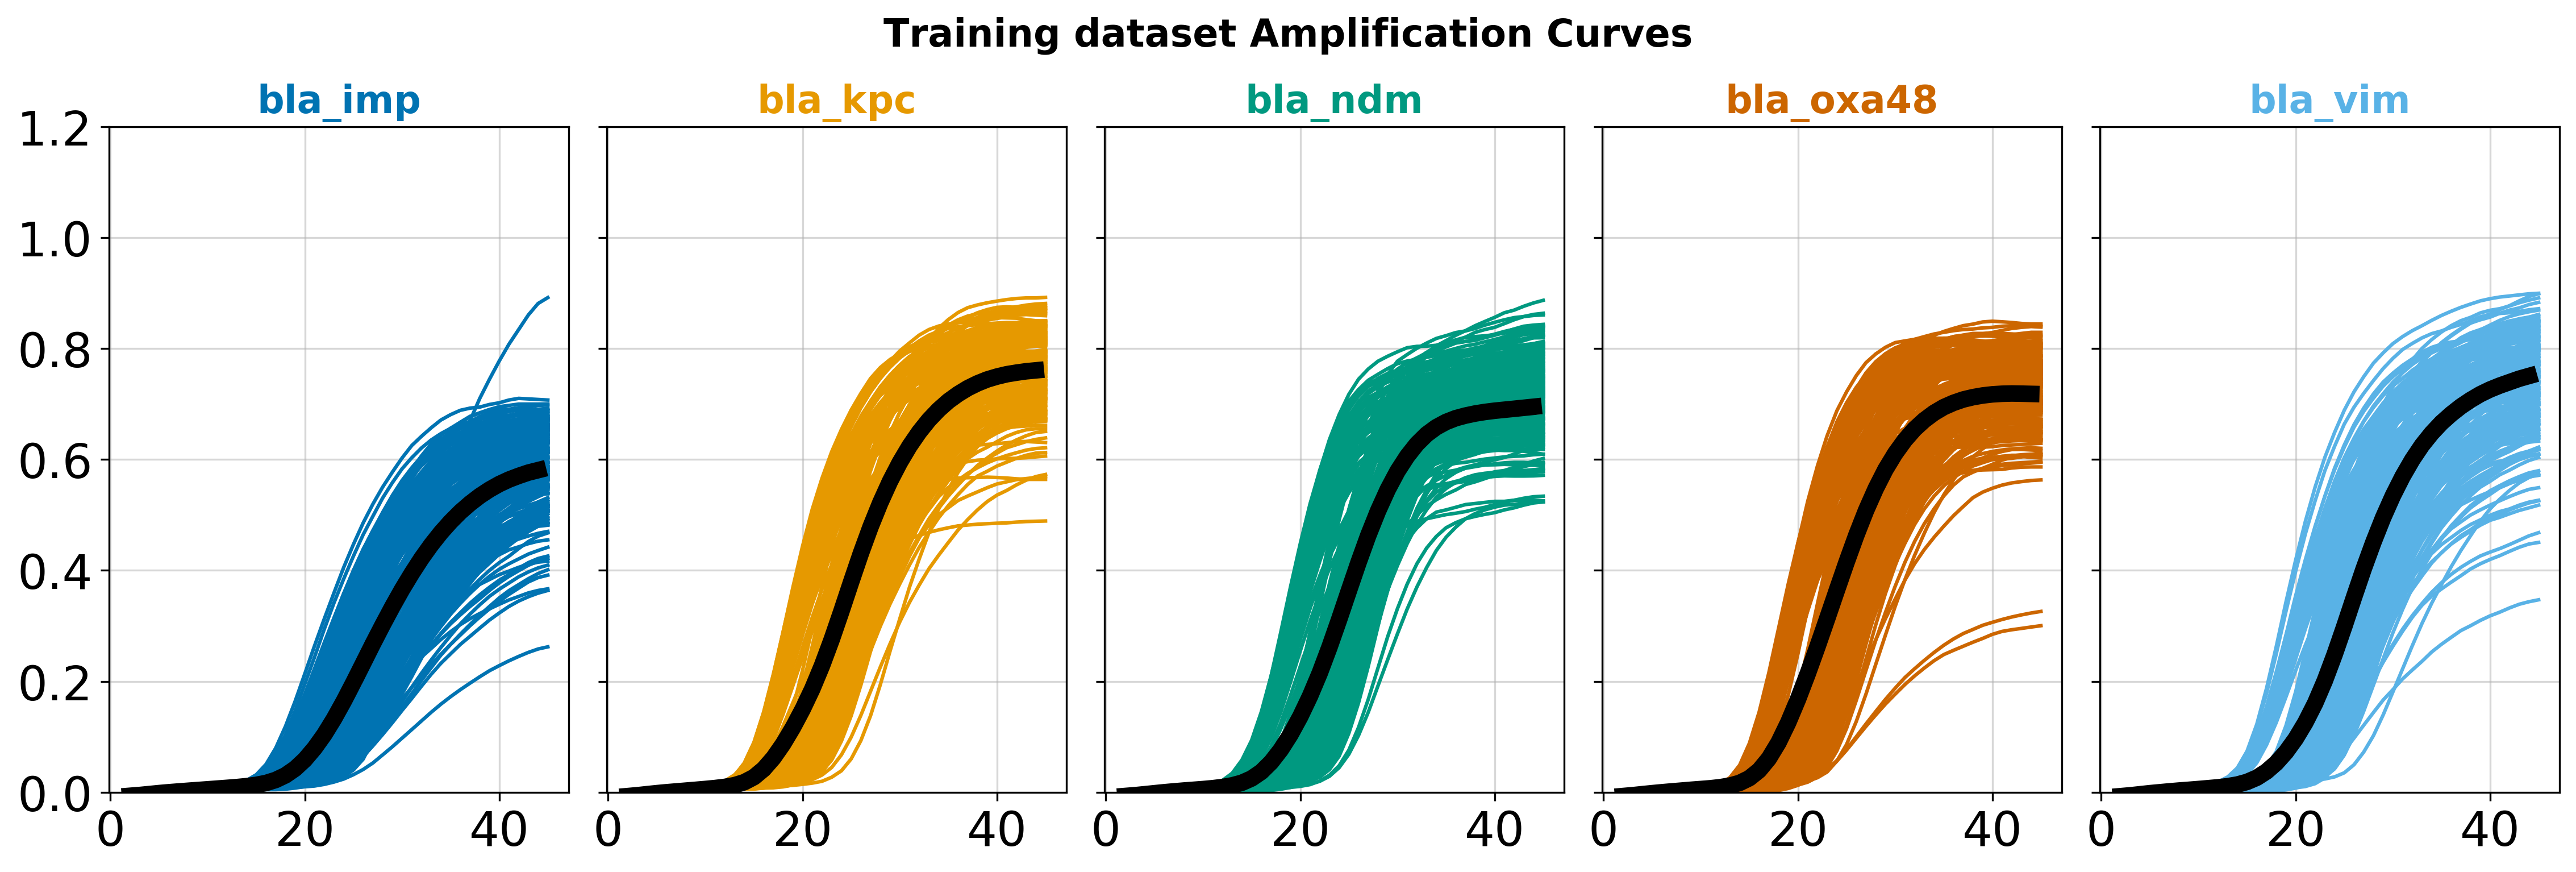

In [7]:
fig, ax = plt.subplots(1,5, figsize=(15, 5), dpi=300, constrained_layout=True)
fig.suptitle(f"Training dataset Amplification Curves", fontsize=16, weight="bold")

for i, (cpe_type, df) in enumerate(tqdm(train_plot.groupby('CPE_type'), leave=False)):

    ax[i].set_title(f'bla_{cpe_type}', fontsize=16, weight='bold', c=f"C{i}")
    curves = df.iloc[:, NMETA:].sample(200).transpose()

    ax[i].plot(curves.index, curves.values, c=f"C{i}")
    ax[i].grid(alpha=0.5)
    ax[i].set_ylim((0, 1.2))

    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20) 

    if i>0:
        ax[i].set_yticklabels([])

    curves2 = train_plot[train_plot.CPE_type==cpe_type].iloc[:, NMETA:].sample(50, replace=True)
    curves2 = curves2.mean()
    ax[i].plot(curves2.index[:-1], curves2.values[:-1], c="black", linewidth=7 , zorder=4)

plt.show()

## Melting Curves

In [8]:
from matplotlib.ticker import FormatStrFormatter

train_plot = df_MC_filt.loc[df_MC_filt.Conc != "unk"]
train_plot = train_plot.set_index('CPE_type')

df_cu = []
for i, df in train_plot.groupby('CPE_type'):
    curves2 = df.iloc[:, NMETA:].mean()
    df_cu.append(curves2)
    
df_curve_black = pd.concat(df_cu,axis=1)

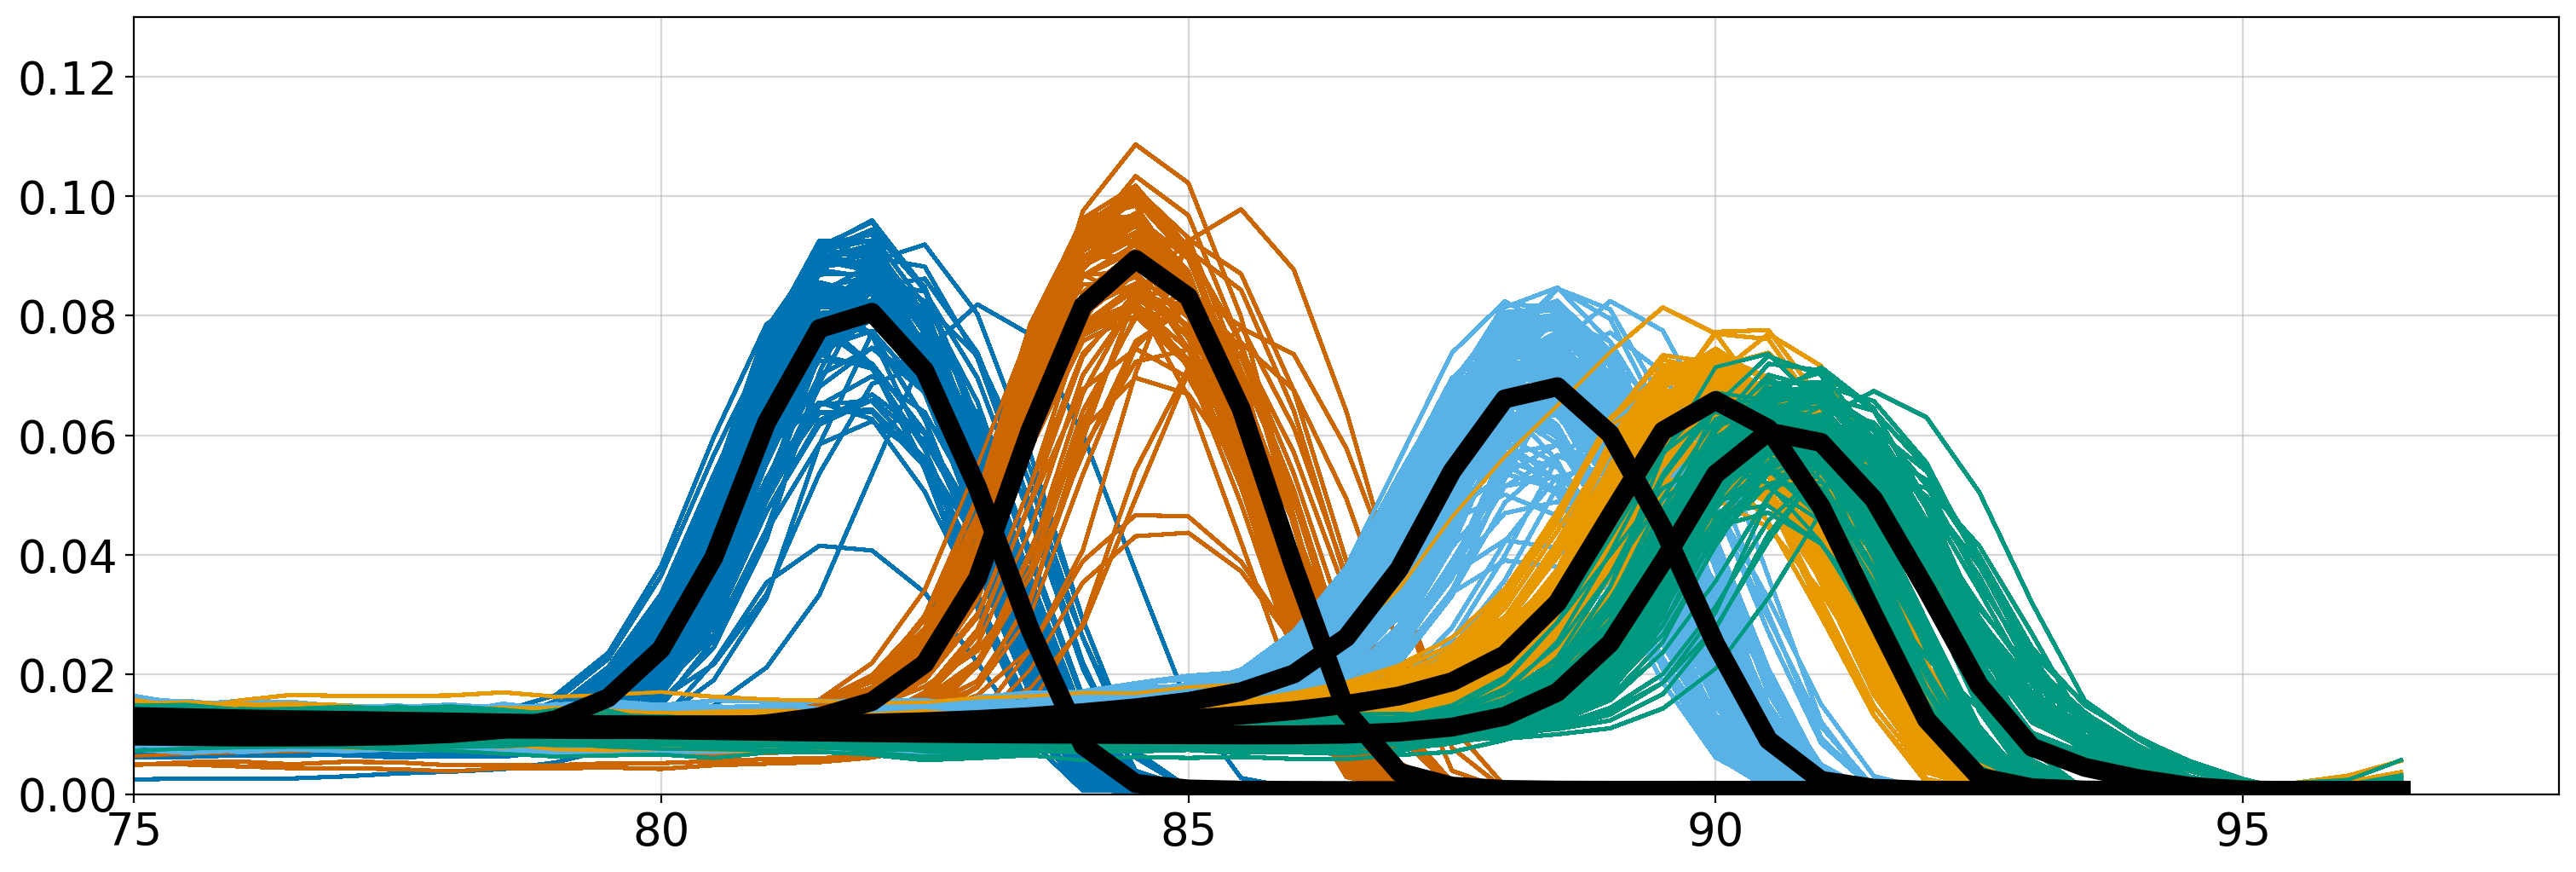

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15, 5), dpi=200, constrained_layout=True)

curves = train_plot.iloc[:, NMETA:].sample(500).transpose()
curves = curves.rename(columns={'imp':'0', 'kpc':'1', 'ndm':'2', 'oxa48':'3', 'vim':"4"})

for col in curves:
    ax.plot(curves[col].index, curves[col].values, c=f'C0{col}')

ax.plot(df_curve_black, c='black', lw=8, zorder=6)    
    
ax.grid(alpha=0.5)
ax.set_ylim((0, 0.13))
ax.set_xlim((75,98))

ax.tick_params(axis='x', labelsize=19)
ax.tick_params(axis='y', labelsize=19) 
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

## Melting peaks distribution

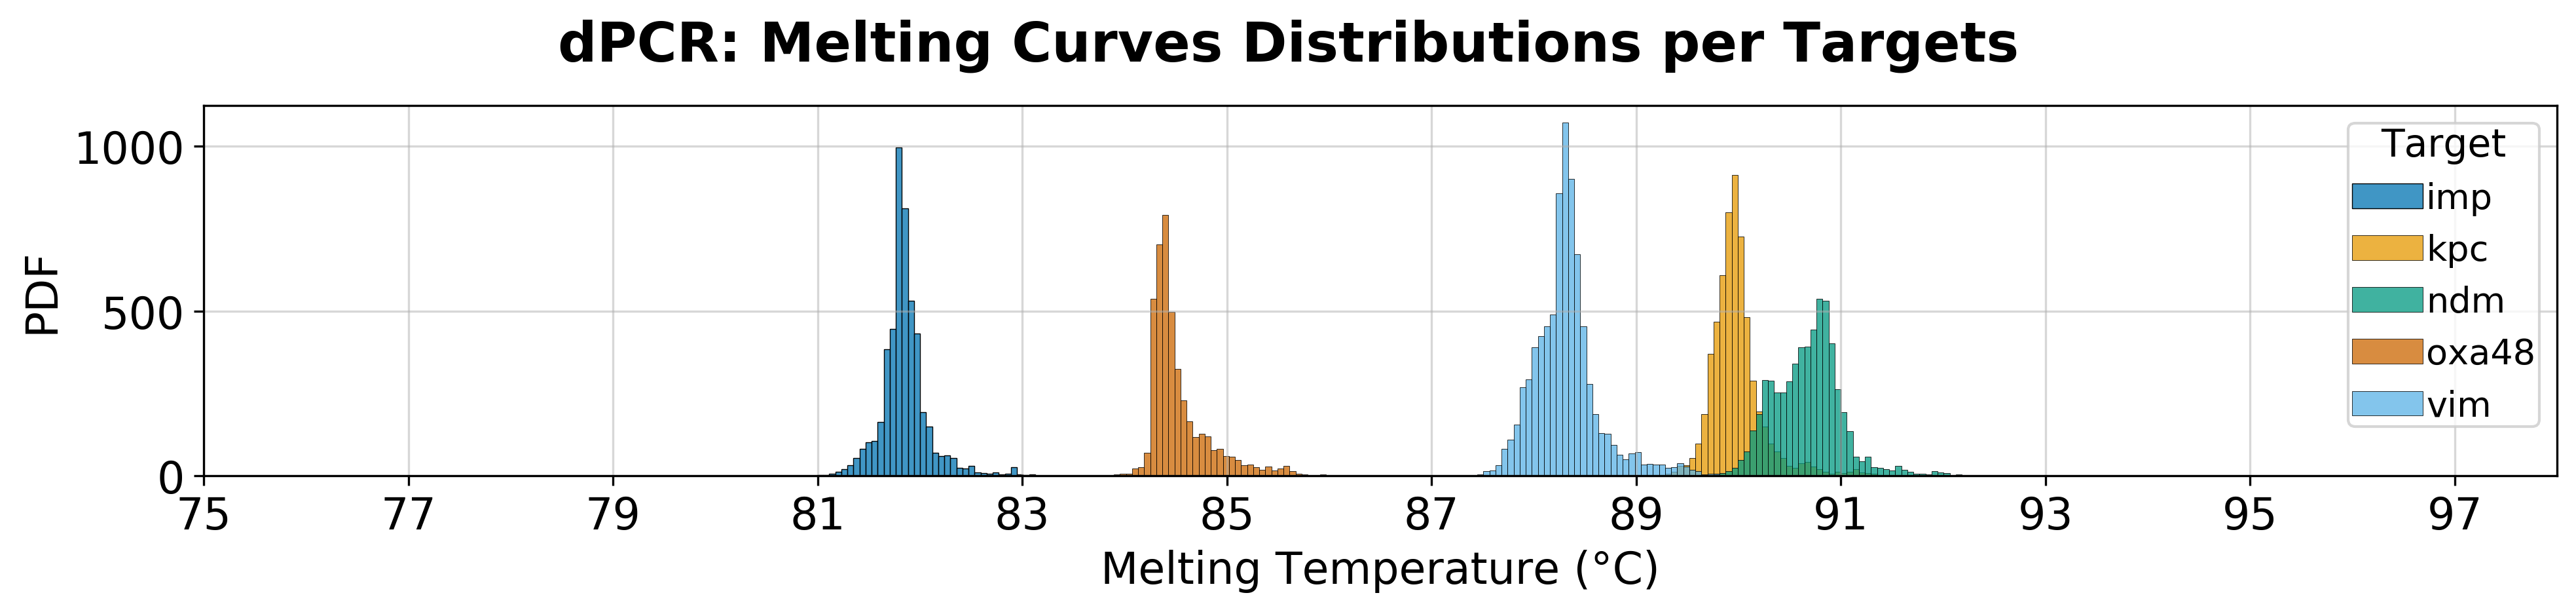

In [10]:
train_plot = df_master.loc[df_master.Conc != 'unk']

bins = np.histogram(train_plot['MeltPeaks'], bins=200)[1]
fig, ax = plt.subplots(1, 1, figsize=(13,3), dpi=300, constrained_layout=True)
fig.suptitle("dPCR: Melting Curves Distributions per Targets", fontsize=20, weight="bold")
  
for i, (target, df) in enumerate(train_plot.groupby('CPE_type')):  
    sns.histplot(df['MeltPeaks'], bins=bins, color=f"C{i}", label=target, ax=ax)

    ax.grid(alpha=0.5)
    ax.set_xlim((75, 98))
    ax.set_xticks(np.arange(75, 98, 2.0))

    ax.set_ylabel("PDF", fontsize=16)
    ax.set_xlabel("Melting Temperature (" + chr(176)+ "C)", fontsize=16)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16) 

ax.legend(title="Target", title_fontsize=14, fontsize=13, borderpad=0.1, handletextpad=0.1)

plt.show()

# MACHINE LEARNING ALGORITHM

In [11]:
# Importing Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [12]:
df_master_dPCR = df_master.copy()
print('total clinical samples', len(df_master_dPCR.loc[df_master_dPCR.Conc=='unk'].Target.unique()))

total clinical samples 221


## Encoding labels and select dataset

In [13]:
X_AC = df_master_dPCR.iloc[:, NMETA+1:].values
X_MC = df_master_dPCR.loc[:, ['MeltPeaks']].values
X_FFI = X_AC[:,[-1]]

encoder_master = LabelEncoder()
encoder_master.fit(df_master_dPCR['CPE_type'])
print('Encoded Targets:', encoder_master.classes_)

ytrue = encoder_master.transform(df_master_dPCR['CPE_type'])

X_MC.shape, X_AC.shape, X_FFI.shape, ytrue.shape

Encoded Targets: ['imp' 'kpc' 'ndm' 'ndm_oxa48' 'oxa48' 'vim']


((160041, 1), (160041, 44), (160041, 1), (160041,))

In [14]:
test_idx = df_master_dPCR.Conc=='unk'
train_idx = ~test_idx

X_AC_train, X_AC_test = X_AC[train_idx], X_AC[test_idx]
X_MC_train, X_MC_test = X_MC[train_idx], X_MC[test_idx]
X_FFI_train, X_FFI_test = X_FFI[train_idx], X_FFI[test_idx]
y_train, y_test = ytrue[train_idx], ytrue[test_idx]

# print('Training on:', y_train.shape[0], ' ///  Testing on:', y_test.shape[0])

## Logistic Regression and KNN

In [15]:
########## create/train model for MC ##########    
clf_MC, clf_MC_proba = mlfunc.train_MCA_model(X_MC_train, y_train, max_iter=1000)

########## create/train model for AC ##########
clf_AC, clf_AC_proba = mlfunc.train_ACA_model(X_AC_train, y_train, n_neighbors=20)

########## create/train model for FFI ##########
clf_FFI, clf_FFI_proba = mlfunc.train_FFI_model(X_FFI_train, y_train, max_iter=1000)

########## create/train model for AMCA ##########
X_AC_MC_train = np.concatenate((clf_MC_proba, clf_AC_proba), axis=1)
clf, clf_proba = mlfunc.train_AMCA_model(X_AC_MC_train, y_train, max_iter=1000, fit_intercept=False)
X_AC_MC_test = np.concatenate((clf_MC.predict_proba(X_MC_test), clf_AC.predict_proba(X_AC_test)), axis=1)

y_preds = clf.predict(X_AC_MC_test)
y_trues = y_test.copy()

y_preds_AC = clf_AC.predict(X_AC_test)
y_preds_MC = clf_MC.predict(X_MC_test)
y_preds_FFI = clf_FFI.predict(X_FFI_test)

idx_confidence = np.ones(len(y_preds_AC), dtype=bool)

## Plotting the Confusion Matrixes

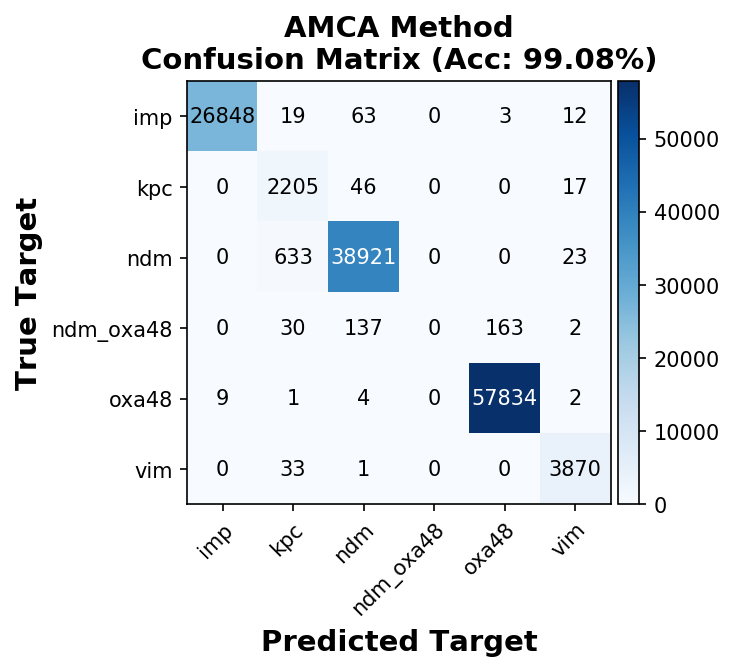

In [16]:
classes = encoder_master.classes_

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

plotfunc.plot_confusion_matrix(y_trues[idx_confidence], y_preds[idx_confidence], classes, ax, normalize=False)
ax.set_title('AMCA Method\n'+ax.get_title(), fontsize=14, weight='bold')
ax.set_ylabel('True Target', fontsize=14, weight='bold')
ax.set_xlabel('Predicted Target', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

## Checking panel Results (sample level)

In [17]:
panel_encoder = LabelEncoder()
ypanel = panel_encoder.fit_transform(df_master_dPCR['Channel']+'_'+df_master_dPCR['Target']+'_'+df_master_dPCR['CPE_type'])
ypanel_train, ypanel_test = ypanel[train_idx], ypanel[test_idx]

In [18]:
def panel_results(ypred, ypanel, encoder):

    N_targets = len(encoder.classes_)

    df_panel_counts = pd.DataFrame(columns=encoder.classes_)
    df_panel_output = pd.DataFrame(columns=['Output'])

    for id_, df_ in pd.DataFrame({'Panel_ID': ypanel, 'Prediction': ypred}).groupby('Panel_ID'):
        empty_series = pd.Series(index=range(N_targets), data=np.zeros(N_targets), dtype=int)
        for i, value in df_['Prediction'].value_counts().items():
            empty_series.loc[i] = value
        df_panel_counts.loc[id_] = empty_series.values

        # WE CLASSIFY PANEL BASED ON HAVING MORE THAN 5% OCCUPANCY
        idx = np.where(empty_series.values>39)[0]
        df_panel_output.loc[id_] = '_'.join(encoder.classes_[idx]) if len(idx)>0 else ['Empty']

    return df_panel_counts, df_panel_output

In [19]:
df_panel_counts_true, df_panel_output_true = panel_results(y_test[idx_confidence], ypanel_test[idx_confidence], encoder_master)
df_panel_counts_true.index = panel_encoder.classes_[df_panel_counts_true.index]
df_panel_output_true.index = panel_encoder.classes_[df_panel_output_true.index]

## Running at Panel level (sample level) the Confusion Matrix classification

In [20]:
which = 'AMCA'

if which == 'AMCA':
    df_panel_counts_pred, df_panel_output_pred = panel_results(y_preds[idx_confidence], ypanel_test[idx_confidence], encoder_master)
elif which == 'MCA':
    df_panel_counts_pred, df_panel_output_pred = panel_results(y_preds_MC[idx_confidence], ypanel_test[idx_confidence], encoder_master)

df_panel_counts_pred.index = panel_encoder.classes_[df_panel_counts_pred.index]
df_panel_output_pred.index = panel_encoder.classes_[df_panel_output_pred.index]

In [21]:
result = df_panel_counts_pred.join(df_panel_output_pred)
result['True'] = ['_'.join(i.split('_')[2:]) for i in result.index]

result.head()

,imp,kpc,ndm,ndm_oxa48,oxa48,vim,Output,True
panel01_CPO040_imp,380,0,0,0,0,0,imp,imp
panel01_CPO050_imp,283,2,0,0,0,0,imp,imp
panel01_CPO121_ndm,0,9,701,0,0,0,ndm,ndm
panel01_CPO171_oxa48,0,0,0,0,763,0,oxa48,oxa48
panel01_CPO182_oxa48,1,0,0,0,768,0,oxa48,oxa48


In [22]:
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_custom_confusion_matrix(y_true, y_pred, classes, ax,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    
    accuracy = 100 * np.mean(y_true==y_pred)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix (Acc: {:.2f}%)'.format(accuracy),
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > 0 else "black")

    ax.grid(False)
    
    for im in ax.get_images():
        im.set_clim(0, 1)

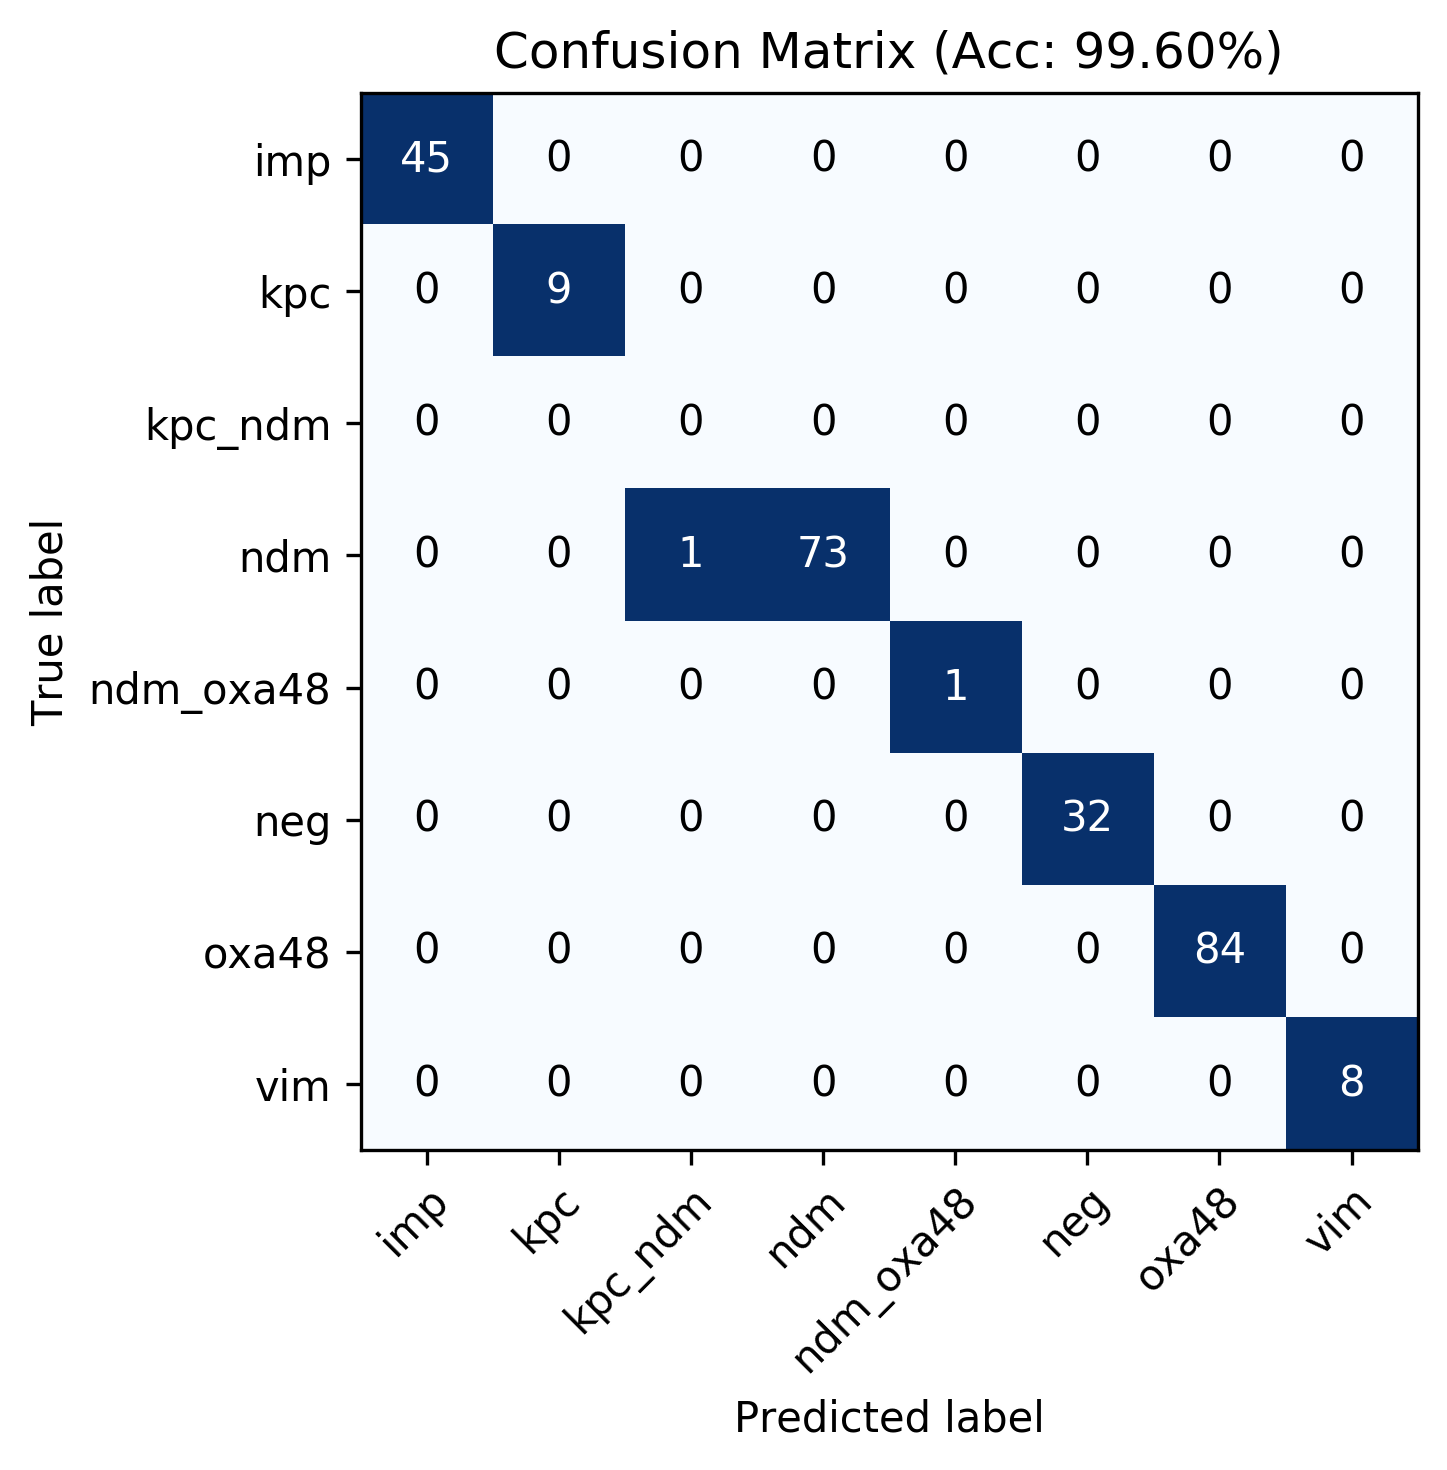

In [23]:
temp = np.append(np.unique(result[['True', 'Output']].values.reshape(-1)), 'neg')

enc = LabelEncoder()
enc.fit(temp)

classes = enc.classes_

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)

plot_custom_confusion_matrix(np.append(enc.transform(result['True'].values.reshape(-1)), 
                                         enc.transform(['neg']*32)), 
                               np.append(enc.transform(result['Output'].values.reshape(-1)), 
                                         enc.transform(['neg']*32)), 
                               classes, ax, normalize=False)

plt.tight_layout()
plt.show()